This notebook shows how to readout the system state from a network structured to implements a dynamical system.

Below shows an NEF network set up as an integrator.

The state of the system is embedded in the synaptic input state of the Ensemble's neurons.
The Ensemble's output spike trains contain the synaptic state information, but in a very noisy form. Reading out from the Ensemble's spikes directly with the `ensemble probe` below shows how noisy it can be.

While filtering the Ensemble's spikes with `filtered ensemble probe` helps the noise, it introduces additional dynamics in the readout.

The right way to do it is to duplicate the Ensemble's inputs to a readout synapse with `readout probe`. This provides a clean readout of the signal while maintaining the correct dynamics.

In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt

Building finished in 0:00:01.                                                                                                                                                                                       
Simulating finished in 0:00:01.                                                                                                                                                                                     


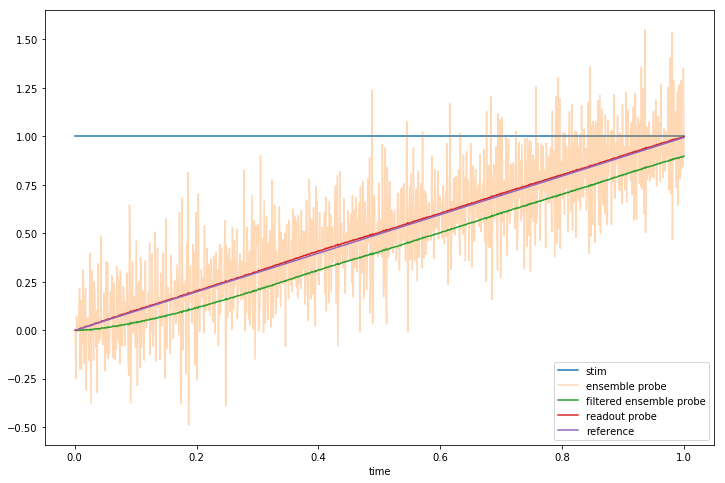

In [2]:
N = 100
T = 1.0

syn_tau=0.1

A = 0
B = 1
A_NEF = syn_tau*A + 1
B_NEF = syn_tau*B

net = nengo.Network()
with net:
    stim = nengo.Node([1])
    # stim = nengo.Node(lambda t: np.sin(2*np.pi*t))
    ens = nengo.Ensemble(N, 1)
    readout = nengo.Node(lambda t, x: x, size_in=1)
    ref = nengo.Node(lambda t, x: x, size_in=1)

    # connect ensemble under test
    nengo.Connection(stim, ens, transform=B_NEF, synapse=syn_tau)
    nengo.Connection(ens, ens, transform=A_NEF, synapse=syn_tau)

    # connect reference system
    nengo.Connection(stim, ref, transform=B_NEF, synapse=syn_tau)
    nengo.Connection(ref, ref, transform=A_NEF, synapse=syn_tau)

    # connect readout
    nengo.Connection(stim, readout, transform=B_NEF, synapse=syn_tau)
    nengo.Connection(ens, readout, transform=A_NEF, synapse=syn_tau)


    probe_stim = nengo.Probe(stim, synapse=None)
    probe_ens = nengo.Probe(ens, synapse=None)
    probe_ens_filt = nengo.Probe(ens, synapse=0.1)
    probe_ref = nengo.Probe(ref, synapse=None)
    probe_readout = nengo.Probe(readout, synapse=None)

sim = nengo.Simulator(net)
sim.run(T)

plt.figure(figsize=(12, 8))
plt.plot(sim.trange(), sim.data[probe_stim], label="stim")
plt.plot(sim.trange(), sim.data[probe_ens], alpha=0.3, label="ensemble probe")
plt.plot(sim.trange(), sim.data[probe_ens_filt], label="filtered ensemble probe")
plt.plot(sim.trange(), sim.data[probe_readout], label="readout probe")
plt.plot(sim.trange(), sim.data[probe_ref], label="reference")
plt.xlabel("time")
plt.legend(loc="lower right")
plt.show()